In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path
from datetime import date
from hmmlearn.hmm import GaussianHMM


Crear cartera equiponderada (sin rebalanceos) compuesta por: 
AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GLD, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, bono del gobierno americano a 10 años, bono del gobierno americano a 2 años y HYG (BAMLH0A0HYM2). 

Fase 1: Detectando el 'Pulso' del Mercado (Hidden Markov Models) 
Objetivo: Considerando la existencia de dos estados de mercado (calma y crisis), identifica, 
para cada día, en qué estado se encuentra el mercado. 
• Tarea  Técnica:  Ajustar  un  modelo  Gaussian  HMM  (Hidden  Markov  Model)  de  2 
estados sobre la serie de retornos multivariante y/o sobre factores representativos. 
• Output Visual: Gráfico del S&P 500 coloreado según el régimen detectado (Blanco = 
Calma, Azul = Crisis).

In [3]:
import sys
print(sys.executable)


c:\Users\Natalia\workplace\Practica-MIAX-gestion-de-riesgos\.venv\Scripts\python.exe


In [4]:
date_init = '2005-12-01'
symbols = ['AAPL','AMZN','BAC','BRK-B','CVX','ENPH','GLD','GME','GOOGL','JNJ','JPM','MSFT','NVDA','PG','XOM']
bons = ['DGS10', 'DGS2']
hyg = 'BAMLH0A0HYM2'

In [5]:
# descargar precios ajustados desde Yahoo hasta hoy
end = pd.Timestamp.today().normalize()
sp500 = yf.download('^GSPC', start=date_init, end=end, auto_adjust=True, progress=False)

sp500 = sp500.rename(columns=str.lower)

# usar solo el cierre
sp500_close = sp500['close']
# calcular retornos diarios
returns = sp500_close.pct_change().dropna()
returns = returns.rename(columns=str.lower)
returns = returns.reset_index().rename(columns={'Date': 'date'})
returns.head()

Ticker,date,^gspc
0,2005-12-02,0.000324
1,2005-12-05,-0.002363
2,2005-12-06,0.001276
3,2005-12-07,-0.005009
4,2005-12-08,-0.001217


El ratio de Amihud captura cuánto se mueve el precio por unidad de volumen negociado:
Amihud_t = |R_t| / Volumen_t
- Si el precio cambia mucho con poco volumen → mercado ilíquido → Amihud alto
- Si el precio cambia poco con mucho volumen → mercado líquido → Amihud bajo
SPY es uno de los activos más líquidos del mundo, así que sus valores de Amihud son extremadamente bajos.

USAR COMO FEATURE DE LIQUIDEZ EM HMM

In [6]:
spy = yf.download('SPY', start=date_init, end=end, auto_adjust=True, progress=False)
spy = spy.rename(columns=str.lower)
spy.index.name = 'date'

spy_ret = spy['close'].pct_change().dropna()

spy_vol = spy['volume']

amihud_spy = (spy_ret['spy'].abs() / spy_vol['spy']).to_frame(name='amihud_sp500')
amihud_spy = amihud_spy.reset_index() 
amihud_spy.head()

,date,amihud_sp500
0,2005-12-01,NaN
1,2005-12-02,2.704433e-11
2,2005-12-05,3.590668e-11
3,2005-12-06,3.272527e-11
4,2005-12-07,8.733312e-11


In [7]:
BASE_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='

def download_fred(serie):
    '''
    Descarga cualquier serie de FRED usando solo pandas.
    serie: código de la serie en FRED (ej: 'DGS10', 'DGS2', 'VIXCLS')
    '''
    url = BASE_URL + serie
    df = pd.read_csv(url)

    # FRED usa 'observation_date' como nombre de columna cambio por 'date' y convertir a datetime
    df.rename(columns={'observation_date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar por fecha de inicio date_init
    df = df[df['date'] >= pd.to_datetime(date_init)]


    # Calcular cambio diario
    df[f'{serie}_change'] = df[serie].diff()

    return df


In [8]:
vixcls = download_fred('VIXCLS')
vixcls.head()


,date,VIXCLS,VIXCLS_change
4152,2005-12-01,11.24,NaN
4153,2005-12-02,11.01,-0.23
4154,2005-12-05,11.60,0.59
4155,2005-12-06,11.52,-0.08
4156,2005-12-07,12.18,0.66


In [9]:
dgs10 = download_fred('DGS10')
dgs10.head()

,date,DGS10,DGS10_change
11457,2005-12-01,4.52,NaN
11458,2005-12-02,4.52,0.00
11459,2005-12-05,4.57,0.05
11460,2005-12-06,4.49,-0.08
11461,2005-12-07,4.52,0.03


In [10]:
dgs2 = download_fred('DGS2')
dgs2.head()

,date,DGS2,DGS2_change
7697,2005-12-01,4.45,NaN
7698,2005-12-02,4.43,-0.02
7699,2005-12-05,4.47,0.04
7700,2005-12-06,4.42,-0.05
7701,2005-12-07,4.42,0.00


In [11]:
hy_oas = download_fred('BAMLH0A0HYM2')
hy_oas.head()

,date,BAMLH0A0HYM2,BAMLH0A0HYM2_change
2357,2005-12-01,3.62,NaN
2358,2005-12-02,3.63,0.01
2359,2005-12-05,3.62,-0.01
2360,2005-12-06,3.68,0.06
2361,2005-12-07,3.66,-0.02


Uso Chicago PMI com proxy porque no esta disponible PMI desde 2003. 
CFNAI =  Chicago Fed National Activity Index. 
Es un idice de 85 indicadores económocos de EEUU. Su objetivo es medir si la economía está por encima de la tendencia histórica o por debajo. Si su valor es menor a  -0.7 es una clara señal de recesión. La versión MA3, es la media movila a 3 meses, se usa en análisis macro porque es más estable y menos ruidosa. 

In [12]:
pmi = download_fred('CFNAIMA3')
pmi_daily = (
    pmi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

pmi_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,CFNAIMA3,CFNAIMA3_change
0,2005-12-01,0.57,NaN
1,2005-12-02,0.57,NaN
2,2005-12-03,0.57,NaN
3,2005-12-04,0.57,NaN
4,2005-12-05,0.57,NaN


CPI es una medida mensual, indica los indice de precios de consumo, la pérdida o ganancia de poder adquisitivo de los hogares

cpi_daily = cpi.set_index("date").resample("D").ffill().reset_index()


In [13]:
cpi = download_fred('CPIAUCSL')
cpi_daily = (
    cpi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

cpi_daily.head() #Todos los datos de diciembre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.


,date,CPIAUCSL,CPIAUCSL_change
0,2005-12-01,198.1,NaN
1,2005-12-02,198.1,NaN
2,2005-12-03,198.1,NaN
3,2005-12-04,198.1,NaN
4,2005-12-05,198.1,NaN


In [14]:
unrate = download_fred('UNRATE')

unrate_daily = (
    unrate
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

unrate_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,UNRATE,UNRATE_change
0,2005-12-01,4.9,NaN
1,2005-12-02,4.9,NaN
2,2005-12-03,4.9,NaN
3,2005-12-04,4.9,NaN
4,2005-12-05,4.9,NaN


El Put/Call Ratio mide el volumen relativo de opciones put frente a opciones call.
Es uno de los indicadores de sentimiento más usados:
- Mayor que 1.0 → sentimiento bajista (más puts que calls)
- Menos que 0.7 → sentimiento alcista (más calls que puts)
- Entre 0.7 y 1.0 → neutral


In [15]:
df_final = (
    returns
    .merge(amihud_spy[['date', 'amihud_sp500']], on='date', how='left')
    .merge(vixcls[['date', 'VIXCLS_change']], on='date', how='left')
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
    .merge(pmi_daily[['date', 'CFNAIMA3_change']], on='date', how='left')
    .merge(cpi_daily[['date', 'CPIAUCSL_change']], on='date', how='left')
    .merge(unrate_daily[['date', 'UNRATE_change']], on='date', how='left')
)
df_final = df_final[df_final['date'] >= '2006-01-01']
df_final.head(500)


,date,^gspc,amihud_sp500,VIXCLS_change,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,CFNAIMA3_change,CPIAUCSL_change,UNRATE_change
20,2006-01-03,0.016430,2.401025e-10,NaN,NaN,NaN,NaN,-0.05,1.200,-0.2
21,2006-01-04,0.003673,9.123724e-11,0.23,-0.01,-0.03,-0.04,-0.05,1.200,-0.2
22,2006-01-05,0.000016,1.328683e-11,-0.06,0.00,0.01,-0.05,-0.05,1.200,-0.2
23,2006-01-06,0.009399,1.323317e-10,-0.31,0.02,0.04,-0.08,-0.05,1.200,-0.2
24,2006-01-09,0.003656,5.902734e-11,0.13,0.00,0.00,-0.05,-0.05,1.200,-0.2
...,...,...,...,...,...,...,...,...,...,...
515,2007-12-20,0.004900,2.935793e-11,-1.10,-0.02,-0.03,0.08,-0.13,0.611,0.3
516,2007-12-21,0.016670,9.867613e-11,-2.11,0.14,0.10,-0.11,-0.13,0.611,0.3
517,2007-12-24,0.008077,1.628603e-10,0.13,0.05,0.05,-0.03,-0.13,0.611,0.3
518,2007-12-26,0.000809,3.195253e-11,NaN,NaN,NaN,NaN,-0.13,0.611,0.3


Con los datos obtenidos se procede a aplicar el modelo modelo  Gaussian  HMM. 

In [26]:
features = [
    '^gspc',
    'amihud_sp500',
    'VIXCLS_change',
    'DGS10_change',
    'DGS2_change',
    'BAMLH0A0HYM2_change',
    'CFNAIMA3_change',
    'CPIAUCSL_change',
    'UNRATE_change'
]
df_final = df_final.sort_values("date").set_index("date")


df_final = df_final.bfill() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.
df_final = df_final.ffill()

df_final = df_final.reset_index()

df_to_HMM = df_final[features].values

In [27]:
model = GaussianHMM(
    n_components=2,        # número de regímenes
    covariance_type='full',
    n_iter=500,
    random_state=42
)

model.fit(df_to_HMM)


,n_components,2
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [34]:
df_final["regime"] = model.predict(df_to_HMM)


In [29]:
df_final.groupby("regime")["^gspc"].mean()


regime
0    0.000544
1   -0.000466
Name: ^gspc, dtype: float64

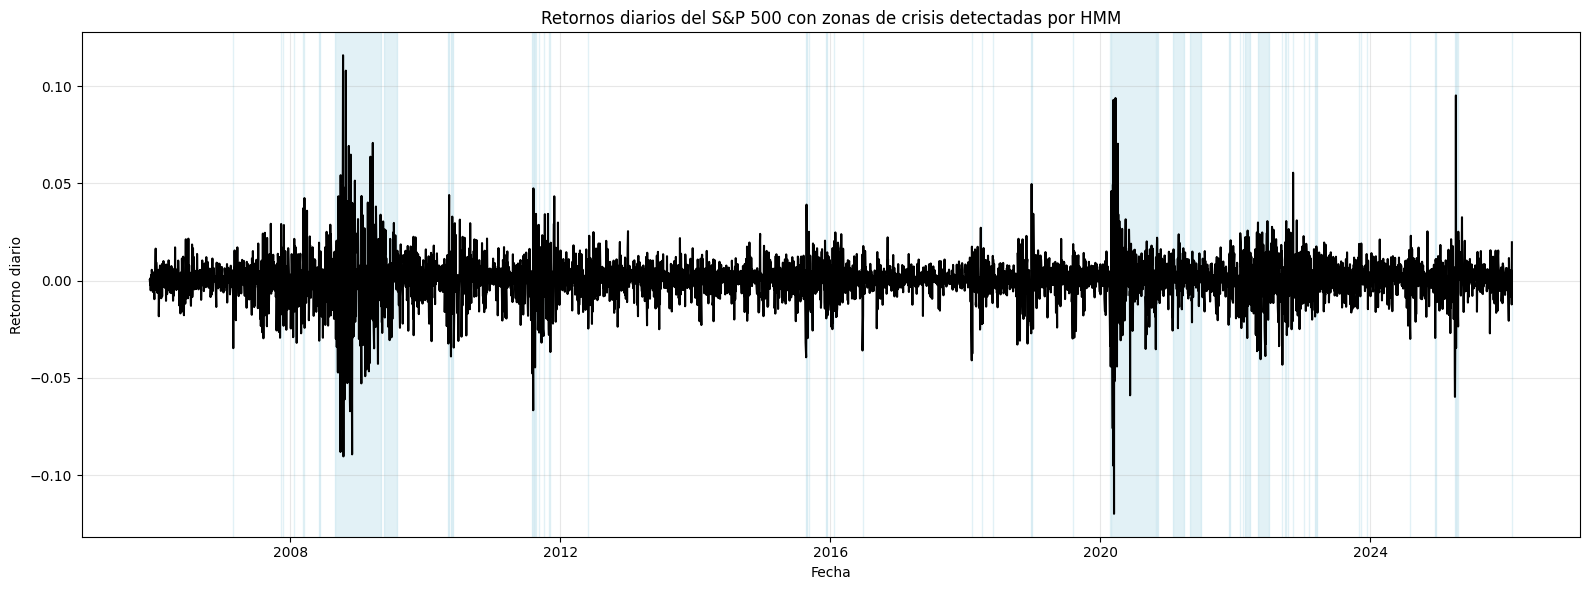

In [38]:
plt.figure(figsize=(16,6))

# Línea continua de los retornos diarios
plt.plot(
    returns["date"],
    returns["^gspc"],
    color="black",
    linewidth=1.5,
    label="Retornos diarios S&P 500"
)

# Unir retornos con los regímenes por fecha
merged = returns.merge(df_final[["date", "regime"]], on="date", how="left")

# Identificar periodos donde regime = 1
crisis_mask = merged["regime"] == 1

# Detectar bloques consecutivos de crisis
merged["crisis_block"] = (crisis_mask != crisis_mask.shift()).cumsum()
crisis_blocks = merged[crisis_mask].groupby("crisis_block")

# Sombrear cada intervalo de crisis
for _, block in crisis_blocks:
    start = block["date"].min()
    end = block["date"].max()
    plt.axvspan(start, end, color="lightblue", alpha=0.35)

# Estética tipo Investing.com
plt.title("Retornos diarios del S&P 500 con zonas de crisis detectadas por HMM")
plt.xlabel("Fecha")
plt.ylabel("Retorno diario")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
